# Plot Global Map of Samples

## Introduction

The publicly available Pf7 dataset for *Plasmodium falciparum* comprises 20,864 samples, collected by 82 partner studies from 33 countries in Africa, Asia, South America and Oceania between 1984 and 2018. In this notebook, we will generate Figure 1 (Panel A) from the [Pf7 paper](https://doi.org/10.12688/wellcomeopenres.18681.1). This figure shows where the samples of the Pf7 dataset were collected on a global map, highlighting the 97 first-level administrative divisions from which samples were taken within countries. On this figure, points represent sampling locations, coloured according to the major sub-population to which the location is assigned. This notebook will demonstrate the code required to generate this figure panel. As one of the Python packages used to generate this panel is now depreciated, this notebook will also demonstrate an alternative method to generate this panel, and output this  as both a .png and .pdf file.

**This notebook should take around 2 minutes to run.**

## Setup

Install the MalariaGEN, basemap, and cartopy packages:

In [ ]:
!pip install -q --no-warn-conflicts malariagen_data
!pip install -q --no-warn-conflicts basemap
!pip install -q --no-warn-conflicts cartopy

Load the required Python libraries:

In [ ]:
import malariagen_data
import pandas as pd
import numpy as np
import collections
import sys
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.image import imread
from mpl_toolkits.basemap import Basemap
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from google.colab import drive


## Data Access
Firstly, load the Pf7 metadata. We then check the 'shape' of the data to make sure it is what we were expecting. This is the full metadata for the Pf7 dataset, which includes 20864 samples, with 17 variables of associated metadata.

In [ ]:
# Load Pf7 data
release_data = malariagen_data.Pf7()
sample_metadata = release_data.sample_metadata()

# View the 'shape' of the data - i.e. how many rows and columns does it have?
print(sample_metadata.shape)


(20864, 17)


Often when working with dataframes such as these, it is useful to check the first few rows of the dataset to make sure it is the correct data and in the format we are expecting. You can see each sample has an ID, information on when and where it was collected, and details on their related genetic data.

In [ ]:
# View the top few rows of the metadata
sample_metadata.head()

Sample              Study     Country   Admin level 1  Country latitude  \
0   FP0008-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
1   FP0009-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
2  FP0010-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
3  FP0011-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
4  FP0012-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   

   Country longitude  Admin level 1 latitude  Admin level 1 longitude    Year  \
0         -10.337093               16.565426                -9.832345  2014.0   
1         -10.337093               16.565426                -9.832345  2014.0   
2         -10.337093               16.565426                -9.832345  2014.0   
3         -10.337093               16.565426                -9.832345  2014.0   
4         -10.337093               16.565426                -9.832345  2014.0   

          ENA All samples same case Population  % callable  QC pass  \
0  ERR1081237              FP0008-C       AF-W       82.16     True   
1  ERR1081238              FP0009-C       AF-W       88.85     True   
2  ERR2889621             FP0010-CW       AF-W       86.46     True   
3  ERR2889624             FP0011-CW       AF-W       86.35     True   
4  ERR2889627             FP0012-CW       AF-W       89.74     True   

  Exclusion reason Sample type  Sample was in Pf6  
0     Analysis_set        gDNA               True  
1     Analysis_set        gDNA               True  
2     Analysis_set        sWGA              False  
3     Analysis_set        sWGA              False  
4     Analysis_set        sWGA              False

## Preparing the data for the figure
In the figure we would like to do three things:

1. Show a world map
2. Highlight the locations from which samples were taken. In our case, this will be as circular points.
2. Colour each point by the sub-population to which the samples were assigned.

To do this, we will start by generating a dictionary object which we can use as a legend for the plot, with the full title for each population:

In [ ]:
#You might have noticed the 'Population' variable in the above meta-data does not contain the full name of each population, only an abbreviation.
#Here, we generate a dictionary which contains the full name of each population. This will be useful later in creating a legend for the plot.
Population_legend = collections.OrderedDict()
Population_legend['SA']       = "South America"
Population_legend['AF-W']     = "Africa - West"
Population_legend['AF-C']     = "Africa - Central"
Population_legend['AF-NE']    = "Africa - Northeast"
Population_legend['AF-E']     = "Africa - East"
Population_legend['AS-S-E']   = "Asia - South - East"
Population_legend['AS-S-FE']  = "Asia - South - Far East"
Population_legend['AS-SE-W']  = "Asia - Southeast - West"
Population_legend['AS-SE-E']  = "Asia - Southeast - East"
Population_legend['OC-NG']    = "Oceania - New Guinea"


We would then like to assign each population a colour:

In [ ]:
# We create a second dictionary object, where each population is given a hexadecimal colour e.g. #4daf4a
Population_colours = collections.OrderedDict()
Population_colours['SA']      = "#4daf4a"
Population_colours['AF-W']    = "#e31a1c"
Population_colours['AF-C']    = "#fd8d3c"
Population_colours['AF-NE']   = "#bb8129"
Population_colours['AF-E']    = "#fecc5c"
Population_colours['AS-S-E']  = "#dfc0eb"
Population_colours['AS-S-FE'] = "#984ea3"
Population_colours['AS-SE-W'] = "#9ecae1"
Population_colours['AS-SE-E'] = "#3182bd"
Population_colours['OC-NG']   = "#f781bf"

# Then we generate a new variable - 'population colour' onto the metadata, and impute the assigned colours using the dictionary
sample_metadata['Population_colour'] = sample_metadata['Population'].map(Population_colours)

# Note we now have an extra colomn
print(sample_metadata.shape)

# Lets check the above has worked by outputting the first few rows of the data, now with the new Population_colour variable
# you will see each population has now been assigned their corresponding colour
sample_metadata.head()


(20864, 18)


Sample              Study     Country   Admin level 1  Country latitude  \
0   FP0008-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
1   FP0009-C  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
2  FP0010-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
3  FP0011-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   
4  FP0012-CW  1147-PF-MR-CONWAY  Mauritania  Hodh el Gharbi         20.265149   

   Country longitude  Admin level 1 latitude  Admin level 1 longitude    Year  \
0         -10.337093               16.565426                -9.832345  2014.0   
1         -10.337093               16.565426                -9.832345  2014.0   
2         -10.337093               16.565426                -9.832345  2014.0   
3         -10.337093               16.565426                -9.832345  2014.0   
4         -10.337093               16.565426                -9.832345  2014.0   

          ENA All samples same case Population  % callable  QC pass  \
0  ERR1081237              FP0008-C       AF-W       82.16     True   
1  ERR1081238              FP0009-C       AF-W       88.85     True   
2  ERR2889621             FP0010-CW       AF-W       86.46     True   
3  ERR2889624             FP0011-CW       AF-W       86.35     True   
4  ERR2889627             FP0012-CW       AF-W       89.74     True   

  Exclusion reason Sample type  Sample was in Pf6 Population_colour  
0     Analysis_set        gDNA               True           #e31a1c  
1     Analysis_set        gDNA               True           #e31a1c  
2     Analysis_set        sWGA              False           #e31a1c  
3     Analysis_set        sWGA              False           #e31a1c  
4     Analysis_set        sWGA              False           #e31a1c

Next, we would like to count the number of samples from each location. Note that we have three levels of information for each location, making it a little tricky. To get counts for each location, we would like each of three category levels to be included:

 1. The population the sample came from (e.g. East Africa)
 2. The country the sample came from (e.g. Kenya)
 3. The administrative level within each country (e.g. Kilifi)

We therefore need to count the number of samples within each sub-category (e.g. East Africa - Kenya - Kilifi). To do this we can create a new dataframe, where we count the number of samples in each sub-category:

In [ ]:
# Here, we create the new dataframe 'sample_metadata_admin1'.
sample_metadata_admin1 = (
    pd.DataFrame(
        sample_metadata                   # we first take the previous dataframe from above
        .groupby(['Population',           # then group the data by several variables (Population, Country & Admin level 1)
                  'Country',
                  'Admin level 1',
                  'Population_colour',    # we also want to include some of the other variables from the previous dataframe (population colour and latitude/longitude)
                  'Admin level 1 latitude',
                  'Admin level 1 longitude'])
        .size()
        .reset_index(name='Number of samples')                       # Then count samples within each subgroup (Population > Country > Admin level 1)
    )

    .set_index(['Country', 'Admin level 1']) # we then set Country and Admin level 1 as the new index
)

# Lets check the above has worked correctly by outputting the new dataframe
pd.options.display.max_rows = 100 # display a maximum of 100 rows
sample_metadata_admin1


Population  \
Country                          Admin level 1                 
Democratic Republic of the Congo Kinshasa               AF-C   
Kenya                            Kilifi                 AF-E   
Madagascar                       Fianarantsoa           AF-E   
                                 Mahajanga              AF-E   
Malawi                           Chikwawa               AF-E   
                                 Zomba                  AF-E   
Mozambique                       Gaza                   AF-E   
Tanzania                         Kagera                 AF-E   
                                 Kigoma                 AF-E   
                                 Lindi                  AF-E   
                                 Morogoro               AF-E   
                                 Tanga                  AF-E   
Ethiopia                         Amhara                AF-NE   
                                 Oromia                AF-NE   
Kenya                            Kisumu                AF-NE   
Sudan                            Blue Nile             AF-NE   
                                 Kassala               AF-NE   
                                 Khartoum              AF-NE   
Uganda                           Apac                  AF-NE   
Benin                            Atlantique             AF-W   
                                 Littoral               AF-W   
Burkina Faso                     Haut-Bassins           AF-W   
Cameroon                         Sud-Ouest              AF-W   
Côte d'Ivoire                    Abidjan                AF-W   
Gabon                            Wouleu-Ntem            AF-W   
Gambia                           North Bank             AF-W   
                                 Upper River            AF-W   
                                 Western                AF-W   
Ghana                            Ashanti                AF-W   
                                 Brong Ahafo            AF-W   
                                 Central                AF-W   
                                 Eastern                AF-W   
                                 Greater Accra          AF-W   
                                 Upper East             AF-W   
                                 Volta                  AF-W   
Guinea                           Faranah                AF-W   
                                 Nzerekore              AF-W   
Mali                             Bamako                 AF-W   
                                 Kayes                  AF-W   
                                 Koulikoro              AF-W   
                                 Mopti                  AF-W   
                                 Segou                  AF-W   
                                 Sikasso                AF-W   
Mauritania                       Guidimaka              AF-W   
                                 Hodh ech Chargui       AF-W   
                                 Hodh el Gharbi         AF-W   
Nigeria                          Kwara                  AF-W   
                                 Lagos                  AF-W   
Senegal                          Dakar                  AF-W   
                                 Sedhiou                AF-W   
India                            Odisha               AS-S-E   
                                 West Bengal          AS-S-E   
Bangladesh                       Chittagong          AS-S-FE   
India                            Tripura             AS-S-FE   
Cambodia                         Battambang          AS-SE-E   
                                 Koh Kong            AS-SE-E   
                                 Pailin              AS-SE-E   
                                 Preah Vihear        AS-SE-E   
                                 Pursat              AS-SE-E   
                                 Ratanakiri          AS-SE-E   
                                 Stueng Traeng       AS-SE-E   
Laos              

## Plotting figure 1A from the Pf7 paper

We can now plot figure 1A from the Pf7 paper. Firstly, we set the basic plotting parameters for the plot, such as the font sizes. We then set the range of latitude and longitude we would like to include in the plot, as well as the total size of the image.

In [ ]:
# Set basic plotting parameters (this is required regardless of whether the 'Basemap' or 'Cartopy' package is used)
rcParams = plt.rcParams
base_font_size = 8
rcParams['font.size'] = base_font_size
rcParams['axes.labelsize'] = base_font_size
rcParams['xtick.labelsize'] = base_font_size
rcParams['ytick.labelsize'] = base_font_size
rcParams['legend.fontsize'] = base_font_size
rcParams['axes.linewidth'] = .5
rcParams['lines.linewidth'] = .5
rcParams['patch.linewidth'] = .5
rcParams['ytick.direction'] = 'out'
rcParams['xtick.direction'] = 'out'
rcParams['lines.markeredgewidth'] = .5
rcParams['figure.max_open_warning'] = 1000

# Define the maximum and minimum latitude and longitude for the map
min_lat = int(sample_metadata_admin1['Admin level 1 latitude'].min()) - 3
max_lat = int(sample_metadata_admin1['Admin level 1 latitude'].max()) + 3
min_long = int(sample_metadata_admin1['Admin level 1 longitude'].min()) - 3
max_long = int(sample_metadata_admin1['Admin level 1 longitude'].max()) + 3

# Then define the total size of the image
map_size = ((int(sample_metadata_admin1['Admin level 1 longitude'].max()) + 3  - int(sample_metadata_admin1['Admin level 1 longitude'].min()) - 3) / 10 ,
(int(sample_metadata_admin1['Admin level 1 latitude'].max()) + 3  -  int(sample_metadata_admin1['Admin level 1 latitude'].min()) - 3 ) / 10 )

### Plotting using the 'Basemap' package
In this first code chunk, we use the Basemap plotting function from the mpl_toolkits package. This code will recreate the image from the published Pf7 paper. However, this package is now deprecated. In future, the map can be recreated using a different map building package - 'cartopy'. The code to generate this plot is in the following code chunk (see below).

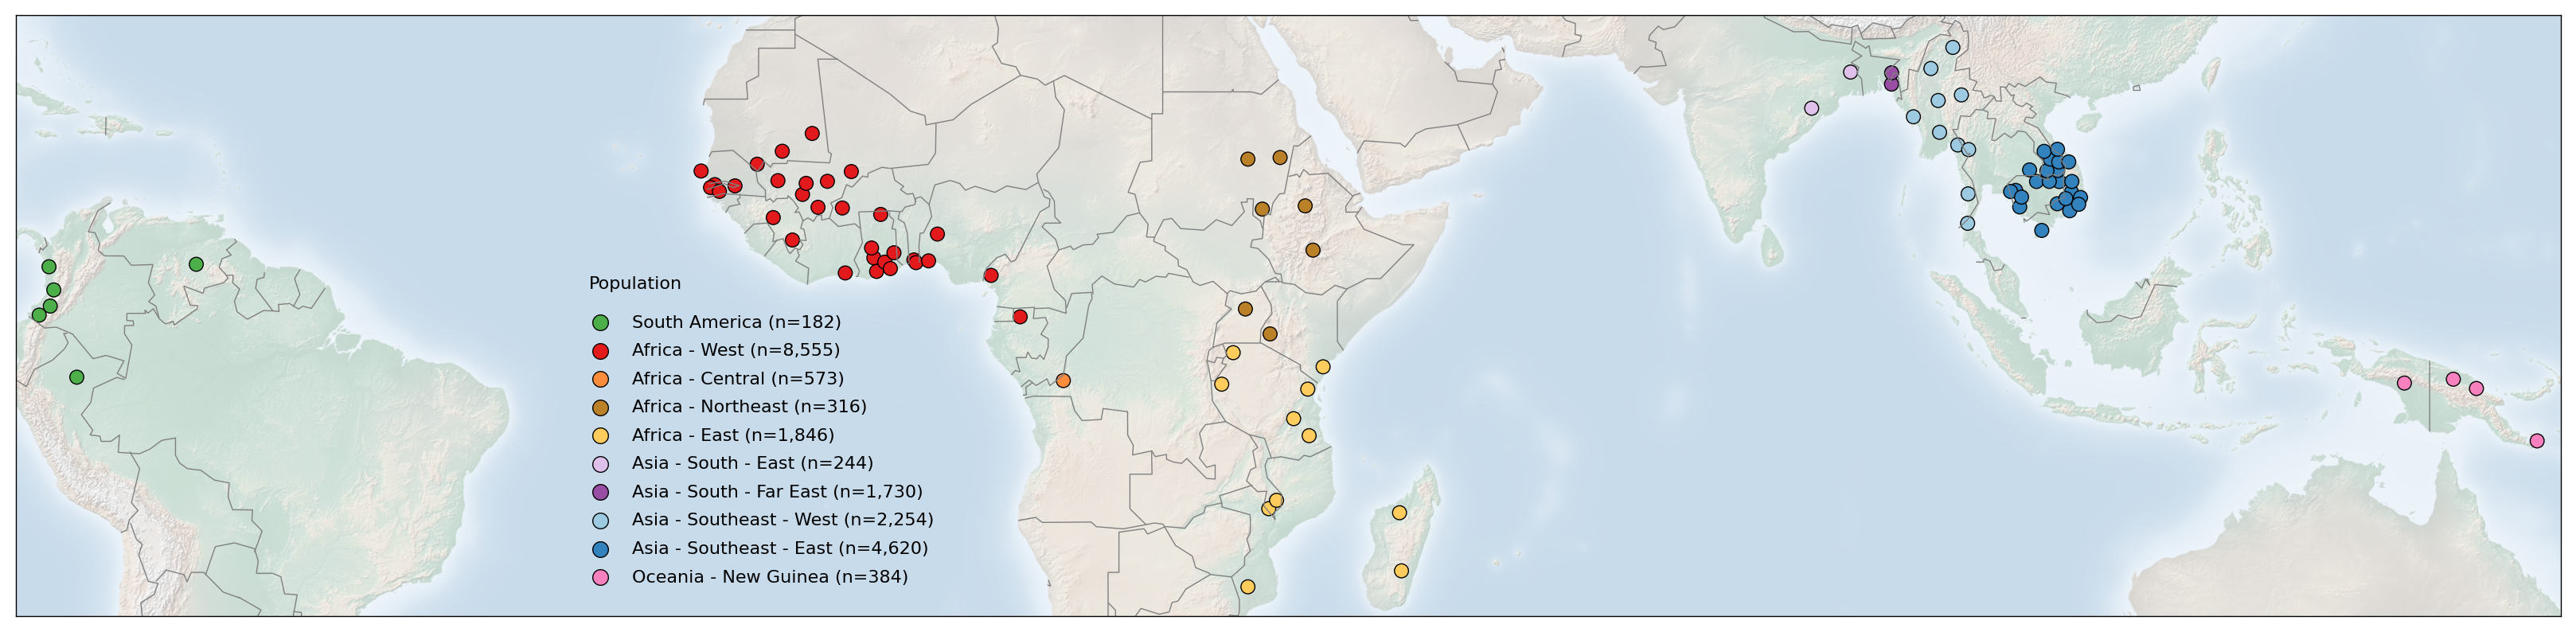

In [ ]:
# 1. Define the figure and axes
fig = plt.figure(figsize=map_size)

alpha = 1.0

# 2. Draw the map background
m = Basemap(projection='cyl', resolution='c',
            llcrnrlat=min_lat, urcrnrlat=max_lat,
            llcrnrlon=min_long, urcrnrlon=max_long
          )

m.shadedrelief(alpha=0.4)
m.drawcountries(color='gray')

# 3. Show admin 1 levels, with color reflecting population
m.scatter(
    sample_metadata_admin1['Admin level 1 longitude'],
    sample_metadata_admin1['Admin level 1 latitude'],
    c=sample_metadata_admin1['Population_colour'],
    edgecolors='black',
    s=40,
    alpha=alpha,
    latlon=True
)

# 4. Make legend with dummy points
for population in Population_colours:
    n = np.count_nonzero(sample_metadata['Population'] == population)
    plt.scatter(
        [],
        [],
        c=Population_colours[population],
        edgecolors='black',
        alpha=alpha,
        s=50,
        label=f"{Population_legend[population]} (n={n:,})"
    )

plt.legend(scatterpoints=1, frameon=False, labelspacing=.7, loc=(0.22, 0.04))
plt.text(-27.5, 4, 'Population')

# 5. Add title (optional)
#plt.title("Figure 1A: Sampling locations")

plt.show()


### Recreating the plot using the 'Cartopy' package

Next, we recreate the plot using the 'Cartopy'. While the code used is not identical to that used for the original plot, it uses the same coordinates and plots the sampling locations of the points to generate a near identical plot. This code should be used in future to generate the figures.

To do this, we first need to download the map image we will use. This first code chunk downloads an image to use from the Natural Earth Data website, this  will be used to generate the plot.

In [ ]:
# First we need to download the map image file via a web link:
!wget https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/HYP_50M_SR_W.zip

# Unzip the file and define the path to the image file:
!unzip './HYP_50M_SR_W.zip'
image = './HYP_50M_SR_W.tif'


--2023-11-15 17:24:25--  https://www.naturalearthdata.com/http//www.naturalearthdata.com/download/50m/raster/HYP_50M_SR_W.zip
Resolving www.naturalearthdata.com (www.naturalearthdata.com)... 50.87.253.14
Connecting to www.naturalearthdata.com (www.naturalearthdata.com)|50.87.253.14|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Location: https://naciscdn.org/naturalearth/50m/raster/HYP_50M_SR_W.zip [following]
--2023-11-15 17:24:25--  https://naciscdn.org/naturalearth/50m/raster/HYP_50M_SR_W.zip
Resolving naciscdn.org (naciscdn.org)... 18.65.229.31, 18.65.229.84, 18.65.229.10, ...
Connecting to naciscdn.org (naciscdn.org)|18.65.229.31|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 102197904 (97M) [application/zip]
Saving to: ‘HYP_50M_SR_W.zip.3’

HYP_50M_SR_W.zip.3  100%[===================>]  97.46M   280MB/s    in 0.3s    

2023-11-15 17:24:26 (280 MB/s) - ‘HYP_50M_SR_W.zip.3’ saved [102197904/102197904]

Archive:  ./HYP_50

'./HYP_50M_SR_W.tif'

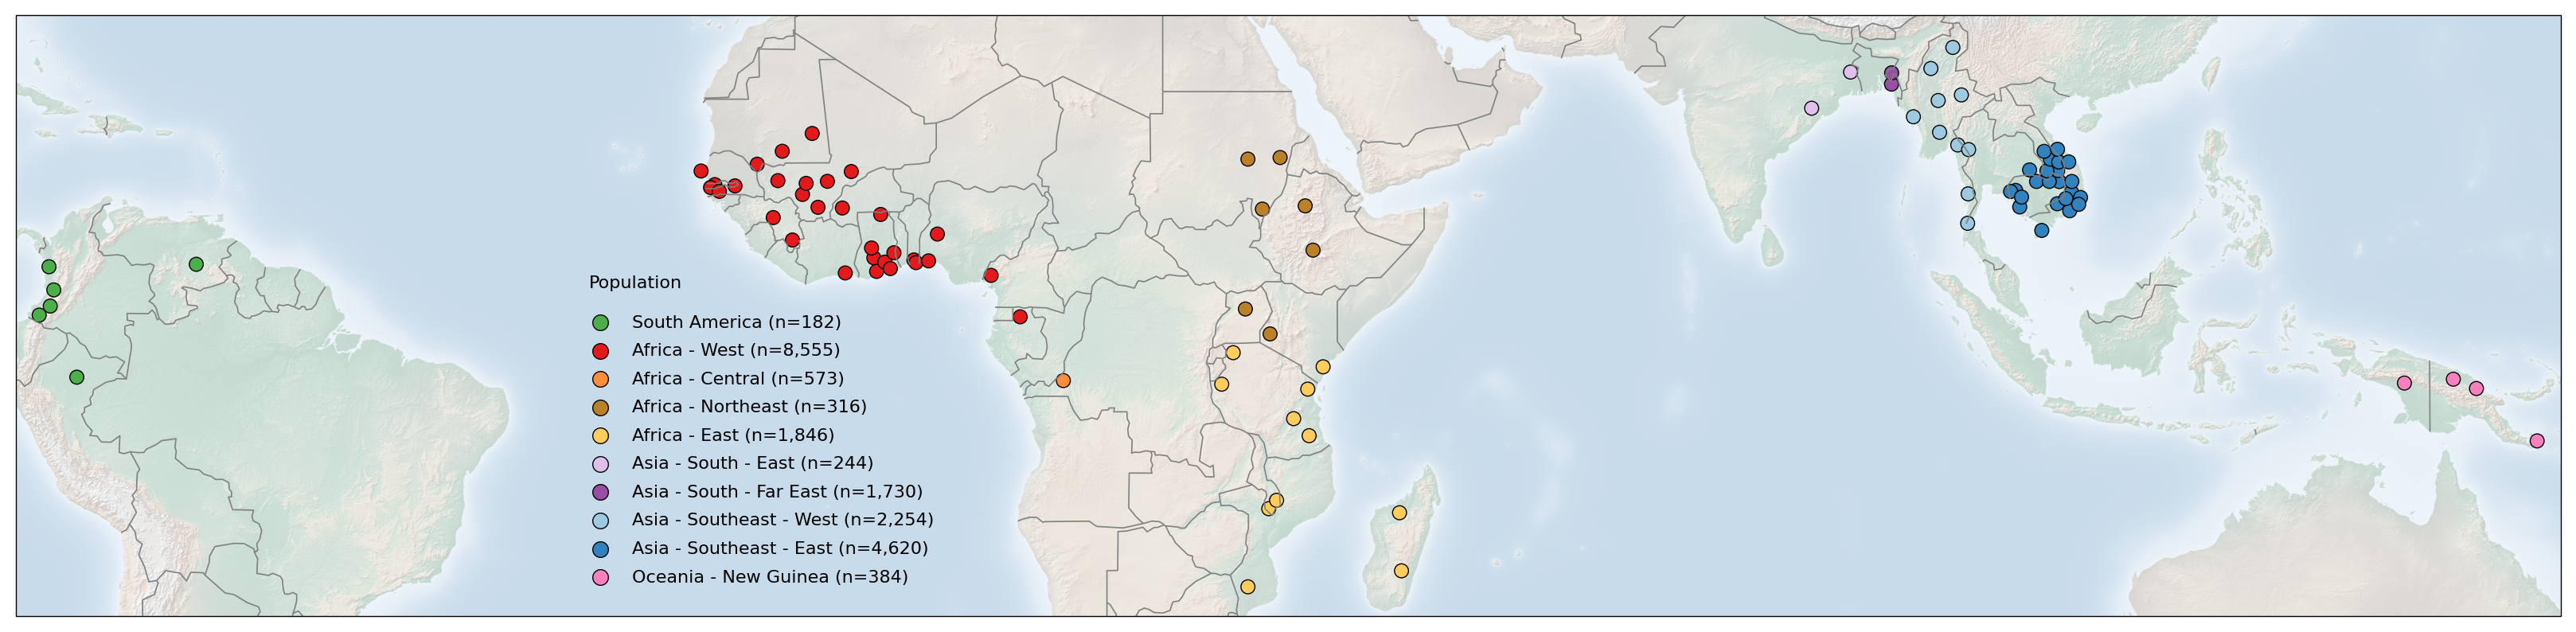

In [ ]:
# 1. Define the figure and axes
fig = plt.figure(figsize=map_size)
alpha = 1.0

# 2. Draw the map background with identical parameters
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_extent([min_long, max_long,min_lat, max_lat], crs=ccrs.PlateCarree())
ax.imshow(imread(image), origin='upper', alpha = 0.4, transform= ccrs.PlateCarree(),
          extent=[-180, 180, -90, 90])
ax.add_feature(cfeature.BORDERS, linestyle='-', linewidth=0.6, edgecolor='grey')

# 3. Show admin 1 levels, with color reflecting population
ax.scatter(
    sample_metadata_admin1['Admin level 1 longitude'],
    sample_metadata_admin1['Admin level 1 latitude'],
    c=sample_metadata_admin1['Population_colour'],
    edgecolors='black',
    s=40,
    alpha=alpha,
    transform=ccrs.PlateCarree()
)

# 4. Make legend with dummy points
for population in Population_colours:
    n = np.count_nonzero(sample_metadata['Population'] == population)
    plt.scatter(
        [],
        [],
        c=Population_colours[population],
        edgecolors='black',
        alpha=alpha,
        s=50,
        label=f"{Population_legend[population]} (n={n:,})"
    )

plt.legend(scatterpoints=1, frameon=False, labelspacing=.7, loc=(0.22, 0.04))
plt.text(-27.5, 4.1, 'Population')

# 5. Add title (optional)
#plt.title("Figure 1A: Sampling locations")

plt.show()


### Save the figure:


In [ ]:
# Mount Google Drive
drive.mount('/content/drive')

# Save sampling locations plot
# This will send the file to your Google Drive, where you can download it from if needed
# Note, this code will only save the updated 'cartopy' version of the plot. If you would like to save the original version instead, you will have to comment out the code chunk which generates the map using cartopy (the chunk directly above this one).
# Change the file path if you wish to send the file to a specific location
# Change the file name if you wish to call it something else
file_path = '/content/drive/My Drive/'
file_name = 'Pf7_figure_1A_sample_collections_map'

# We save as both .png and .PDF files
fig.savefig(f'{file_path}{file_name}.png', dpi=250)
fig.savefig(f'{file_path}{file_name}.pdf')

## Conclusion

In summary, in this notebook, we accessed the MalariaGEN data available on the cloud for the latest *Plasmodium falciparum* data release (Pf7). We then recreated the Figure 1A plot from the Pf7 paper using the 'Basemap' package. As this package is now depreciated, we then updated the plot for future data releases using the cartopy package, and output this as both a .png and .pdf file.
